In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path
import yaml
import re

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model5
ndbs
Wed Jan  5 15:58:29 PST 2022


# Load output

In [2]:
results = csr.VivariumResults.cleaned_from_model_spec('5.1.2')
results.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'births',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

# Look at births table

In [3]:
results.births

,sex,year,measure,input_draw,scenario,value
0,female,2022,birth_weight_sum,29,baseline,3.511416e+07
1,female,2022,birth_weight_sum,29,sqlns,3.511416e+07
2,female,2022,birth_weight_sum,29,wasting_treatment,3.511416e+07
3,female,2022,birth_weight_sum,223,baseline,3.441327e+07
...,...,...,...,...,...,...
1076,male,2026,total_births,829,wasting_treatment,1.111800e+04
1077,male,2026,total_births,946,baseline,1.108200e+04
1078,male,2026,total_births,946,sqlns,1.108200e+04
1079,male,2026,total_births,946,wasting_treatment,1.108200e+04


In [4]:
results.births.measure.unique()

array(['birth_weight_sum', 'low_weight_births', 'total_births'],
      dtype=object)

In [5]:
# 2 sexes x 5 years x 3 measures x 12 draws x 3 scenarios = 1080 rows
2*5*3*12*3

1080

# Write and test functions to compute prevalence of low birthweight and mean birthweight

In [6]:
def get_low_birthweight_prevalence(data, strata, prefilter_query=None, **kwargs):
    if prefilter_query is None:
        prefilter_query = ''
    else:
        prefilter_query += ' and '
    numerator = data['births'].query(f"{prefilter_query}measure=='low_weight_births'")
    denominator = data['births'].query(f"{prefilter_query}measure=='total_births'")
    prevalence = vp.ratio(
        numerator,
        denominator,
        strata,
        **kwargs,
    ).assign(measure='prevalence')
    return prevalence

# Generalized version, which may or may not apply in other situations:
def get_population_prevalence(data, category, population_measure, strata, prefilter_query=None, **kwargs):
    """
    Usage:
    get_population_prevalence(data, 'low_weight', 'births', strata, prefilter_query, **kwargs)
    
    I'm calling this "population" prevalence as opposed to "person-time-weighted" prevalence,
    which is how we usually compute prevalence (e.g. in my `get_prevalence` function),
    because we're using counting measure on the population rather than person-time measure.
    """
    if prefilter_query is None:
        prefilter_query = ''
    else:
        prefilter_query += ' and '
    numerator = data[population_measure].query(f"{prefilter_query}measure=='{category}_{population_measure}'")
    denominator = data[population_measure].query(f"{prefilter_query}measure=='total_{population_measure}'")
    prevalence = vp.ratio(
        numerator,
        denominator,
        strata,
        **kwargs,
    ).assign(measure=f"prevalence")
    return prevalence

# This version doesn't quite work with my current ratio function
# because of differnt values in 'measure' column:
def get_population_prevalence2(data, population_measure, strata, prefilter_query=None, **kwargs):
    """
    Usage:
    get_population_prevalence(data, 'low_weight', 'births', strata, prefilter_query, **kwargs)
    """
    if prefilter_query is None:
        prefilter_query = ''
    else:
        prefilter_query += ' and '
    # Broadcast the numerator over the measure column to compute the prevalence of each category
    kwargs['numerator_broadcast'] = vp.list_columns(
        'measure', kwargs.get('numerator_broadcast'), default=[])
    denominator_measure=f'total_{population_measure}'
    numerator = data[population_measure].query(f"{prefilter_query}measure!={denominator_measure!r}")
    denominator = data[population_measure].query(f"{prefilter_query}measure=={denominator_measure!r}")
    prevalence = vp.ratio(
        numerator,
        denominator,
        strata,
        **kwargs,
    ).assign(measure=f"prevalence")
    return prevalence

def get_birthweight_mean(data, strata, prefilter_query=None, **kwargs):
    if prefilter_query is None:
        prefilter_query = ''
    else:
        prefilter_query += ' and '
    numerator = data['births'].query(f"{prefilter_query}measure=='birth_weight_sum'")
    denominator = data['births'].query(f"{prefilter_query}measure=='total_births'")
    mean = vp.ratio(
        numerator,
        denominator,
        strata,
        **kwargs,
    ).assign(measure='mean')
    return mean

# Generalized version, which may or may not apply in other situations:
def get_population_mean(data, attribute, population_measure, strata, prefilter_query=None, **kwargs):
    """
    Usage:
    get_population_mean(data, 'birth_weight', 'births', strata, prefilter_query, **kwargs)
    
    I'm calling this a "population" mean as opposed to a "person-time weighted" mean,
    because we're using counting measure on the population rather than person-time measure.
    """
    if prefilter_query is None:
        prefilter_query = ''
    else:
        prefilter_query += ' and '
    numerator = data[population_measure].query(f"{prefilter_query}measure=='{attribute}_sum'")
    denominator = data[population_measure].query(f"{prefilter_query}measure=='total_{population_measure}'")
    prevalence = vp.ratio(
        numerator,
        denominator,
        strata,
        **kwargs,
    ).assign(measure=f"mean")
    return prevalence

In [7]:
get_low_birthweight_prevalence(results, [])

,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier,measure
0,29,baseline,0.086541,low_weight_births,total_births,1,prevalence
1,29,sqlns,0.086541,low_weight_births,total_births,1,prevalence
2,29,wasting_treatment,0.086541,low_weight_births,total_births,1,prevalence
3,223,baseline,0.098114,low_weight_births,total_births,1,prevalence
...,...,...,...,...,...,...,...
32,829,wasting_treatment,0.090991,low_weight_births,total_births,1,prevalence
33,946,baseline,0.092160,low_weight_births,total_births,1,prevalence
34,946,sqlns,0.092160,low_weight_births,total_births,1,prevalence
35,946,wasting_treatment,0.092160,low_weight_births,total_births,1,prevalence


In [8]:
get_population_prevalence(results, 'low_weight', 'births', [])

,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier,measure
0,29,baseline,0.086541,low_weight_births,total_births,1,prevalence
1,29,sqlns,0.086541,low_weight_births,total_births,1,prevalence
2,29,wasting_treatment,0.086541,low_weight_births,total_births,1,prevalence
3,223,baseline,0.098114,low_weight_births,total_births,1,prevalence
...,...,...,...,...,...,...,...
32,829,wasting_treatment,0.090991,low_weight_births,total_births,1,prevalence
33,946,baseline,0.092160,low_weight_births,total_births,1,prevalence
34,946,sqlns,0.092160,low_weight_births,total_births,1,prevalence
35,946,wasting_treatment,0.092160,low_weight_births,total_births,1,prevalence


In [9]:
get_population_prevalence(results, 'birth_weight_sum', 'births', [])

,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier,measure
0,29,baseline,NaN,,total_births,1,prevalence
1,29,sqlns,NaN,,total_births,1,prevalence
2,29,wasting_treatment,NaN,,total_births,1,prevalence
3,223,baseline,NaN,,total_births,1,prevalence
...,...,...,...,...,...,...,...
32,829,wasting_treatment,NaN,,total_births,1,prevalence
33,946,baseline,NaN,,total_births,1,prevalence
34,946,sqlns,NaN,,total_births,1,prevalence
35,946,wasting_treatment,NaN,,total_births,1,prevalence


In [10]:
get_population_prevalence2(results, 'births', [])

,input_draw,scenario,measure,value,numerator_measure,denominator_measure,multiplier
0,29,baseline,prevalence,3213.168132,birth_weight_sum|low_weight_births,total_births,1
1,29,baseline,prevalence,0.086541,birth_weight_sum|low_weight_births,total_births,1
2,29,sqlns,prevalence,3213.168132,birth_weight_sum|low_weight_births,total_births,1
3,29,sqlns,prevalence,0.086541,birth_weight_sum|low_weight_births,total_births,1
...,...,...,...,...,...,...,...
68,946,sqlns,prevalence,3217.118864,birth_weight_sum|low_weight_births,total_births,1
69,946,sqlns,prevalence,0.092160,birth_weight_sum|low_weight_births,total_births,1
70,946,wasting_treatment,prevalence,3217.118864,birth_weight_sum|low_weight_births,total_births,1
71,946,wasting_treatment,prevalence,0.092160,birth_weight_sum|low_weight_births,total_births,1


In [11]:
get_birthweight_mean(results, [])

,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier,measure
0,29,baseline,3213.168132,birth_weight_sum,total_births,1,mean
1,29,sqlns,3213.168132,birth_weight_sum,total_births,1,mean
2,29,wasting_treatment,3213.168132,birth_weight_sum,total_births,1,mean
3,223,baseline,3174.110960,birth_weight_sum,total_births,1,mean
...,...,...,...,...,...,...,...
32,829,wasting_treatment,3250.981991,birth_weight_sum,total_births,1,mean
33,946,baseline,3217.118864,birth_weight_sum,total_births,1,mean
34,946,sqlns,3217.118864,birth_weight_sum,total_births,1,mean
35,946,wasting_treatment,3217.118864,birth_weight_sum,total_births,1,mean


In [12]:
get_population_mean(results, 'birth_weight', 'births', [])

,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier,measure
0,29,baseline,3213.168132,birth_weight_sum,total_births,1,mean
1,29,sqlns,3213.168132,birth_weight_sum,total_births,1,mean
2,29,wasting_treatment,3213.168132,birth_weight_sum,total_births,1,mean
3,223,baseline,3174.110960,birth_weight_sum,total_births,1,mean
...,...,...,...,...,...,...,...
32,829,wasting_treatment,3250.981991,birth_weight_sum,total_births,1,mean
33,946,baseline,3217.118864,birth_weight_sum,total_births,1,mean
34,946,sqlns,3217.118864,birth_weight_sum,total_births,1,mean
35,946,wasting_treatment,3217.118864,birth_weight_sum,total_births,1,mean


# Create an empty dictionary for saving plots

In [13]:
figs = {}

# Compute and plot prevalence of low birthweight by scenario

There are no interventions yet, so the values should be identical across scenarios.

In [14]:
prevalence_lbw = get_population_prevalence(results, 'low_weight', 'births', ['sex', 'year'], multiplier=100)
prevalence_lbw

,sex,year,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier,measure
0,female,2022,29,baseline,6.901697,low_weight_births,total_births,100,prevalence
1,female,2022,29,sqlns,6.901697,low_weight_births,total_births,100,prevalence
2,female,2022,29,wasting_treatment,6.901697,low_weight_births,total_births,100,prevalence
3,female,2022,223,baseline,8.200113,low_weight_births,total_births,100,prevalence
...,...,...,...,...,...,...,...,...,...
356,male,2026,829,wasting_treatment,10.649397,low_weight_births,total_births,100,prevalence
357,male,2026,946,baseline,10.792276,low_weight_births,total_births,100,prevalence
358,male,2026,946,sqlns,10.792276,low_weight_births,total_births,100,prevalence
359,male,2026,946,wasting_treatment,10.792276,low_weight_births,total_births,100,prevalence


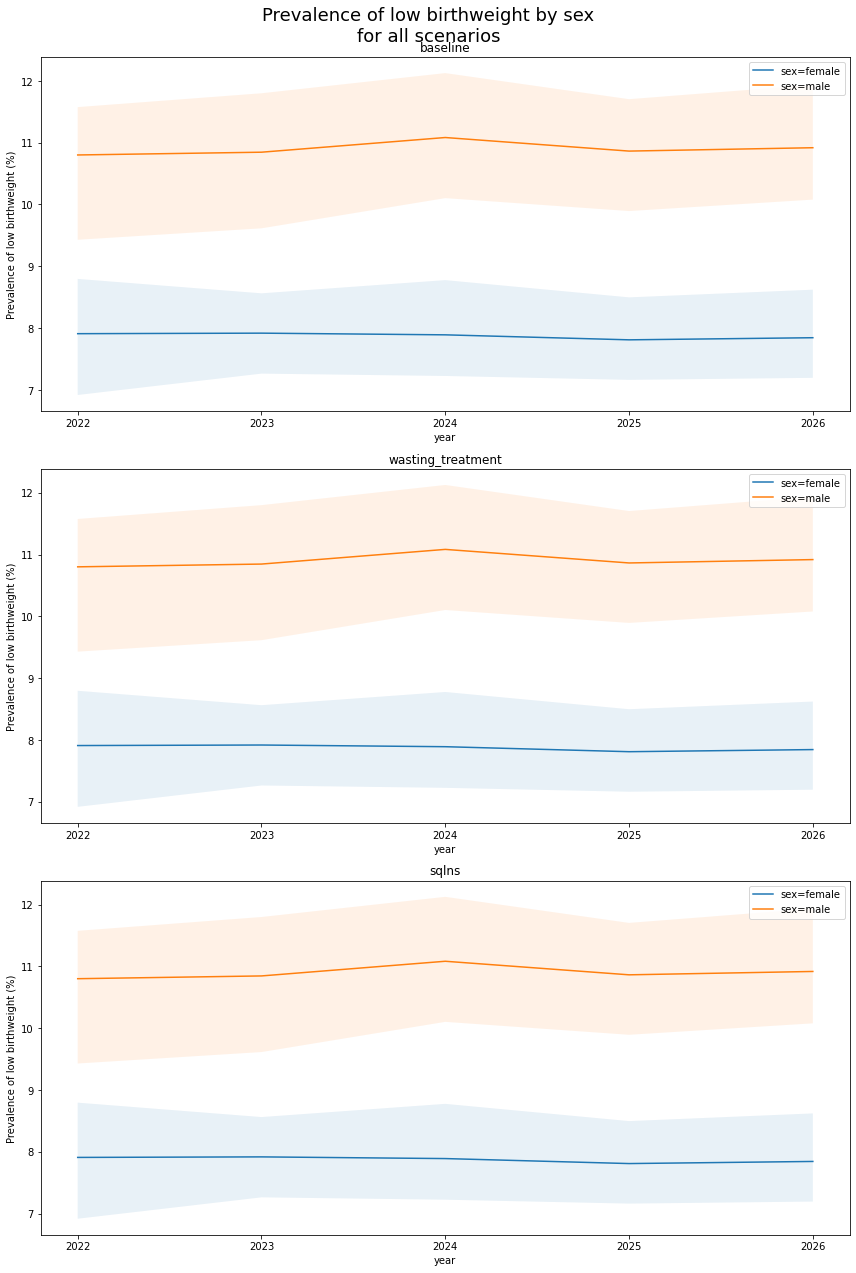

In [15]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    prevalence_lbw,
    'sex',
    'Prevalence of low birthweight (%)',
    title := 'Prevalence of low birthweight by sex\nfor all scenarios',
    True
)
figs[title] = fig

# Compute and plot mean birthweight by scenario

There are no interventions yet, so the values should be identical across scenarios.

In [16]:
mean_birthweight = get_population_mean(results, 'birth_weight', 'births', ['sex', 'year'])
mean_birthweight

,sex,year,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier,measure
0,female,2022,29,baseline,3274.963174,birth_weight_sum,total_births,1,mean
1,female,2022,29,sqlns,3274.963174,birth_weight_sum,total_births,1,mean
2,female,2022,29,wasting_treatment,3274.963174,birth_weight_sum,total_births,1,mean
3,female,2022,223,baseline,3236.154862,birth_weight_sum,total_births,1,mean
...,...,...,...,...,...,...,...,...,...
356,male,2026,829,wasting_treatment,3159.489284,birth_weight_sum,total_births,1,mean
357,male,2026,946,baseline,3120.546798,birth_weight_sum,total_births,1,mean
358,male,2026,946,sqlns,3120.546798,birth_weight_sum,total_births,1,mean
359,male,2026,946,wasting_treatment,3120.546798,birth_weight_sum,total_births,1,mean


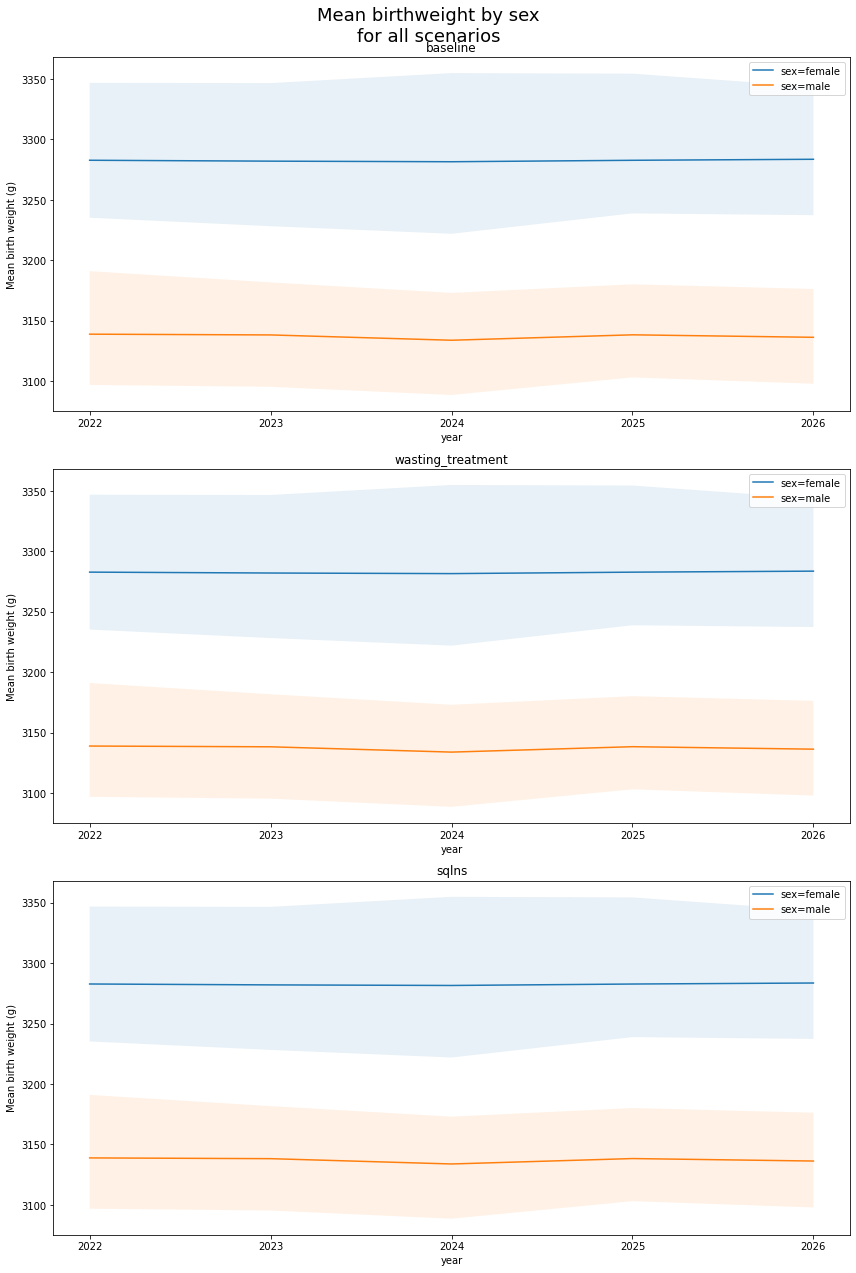

In [17]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    mean_birthweight,
    'sex',
    'Mean birth weight (g)',
    title := 'Mean birthweight by sex\nfor all scenarios',
    True
)
figs[title] = fig

# Create output directories and save figures

In [18]:
figs

{'Prevalence of low birthweight by sex\nfor all scenarios': <Figure size 864x1296 with 3 Axes>,
 'Mean birthweight by sex\nfor all scenarios': <Figure size 864x1296 with 3 Axes>}

In [19]:
[csp.convert_to_variable_name(title) for title in figs.keys()]

['Prevalence_of_low_birthweight_by_sex_for_all_scenarios',
 'Mean_birthweight_by_sex_for_all_scenarios']

In [20]:
csr.get_count_data_path('5.1.2')

'/ihme/costeffectiveness/results/vivarium_ciff_sam/v5.1.2_lbwsg_with_observer/ciff_sam/2021_12_29_17_30_01/count_data/'

In [21]:
username = 'ndbs'
model_name = 'v5.1.2_lbwsg_with_observer'

In [22]:
directories = csp.create_output_directories(username, model_name)
directories

['/ihme/homes/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v5.1.2_lbwsg_with_observer',
 '/home/j/Project/simulation_science/ciff_malnutrition/verification_and_validation/v5.1.2_lbwsg_with_observer']

In [23]:
csp.save_figures(figs, directories)